<a href="https://colab.research.google.com/github/01Joseph-Hwang10/AI_fundamentals/blob/main/aip2_assignment_lab09_CNNpart2_20211381.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 5

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU not found')
print(f'GPU found at: {device_name}')

GPU found at: /device:GPU:0


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt


In [ ]:
class ResidualUnit(keras.layers.Layer): # ResNet-34

  def __init__(self, filters, strides=1, activation="relu", **kwargs):
    super().__init__(**kwargs)
    self.activation = keras.activations.get(activation) # relu activation in this example
    self.main_layers = [
                        keras.layers.Conv2D(filters, 3, strides=strides, padding="same", use_bias=False),
                        keras.layers.BatchNormalization(),
                        self.activation,
                        keras.layers.Conv2D(filters, 3, strides=1, padding="same", use_bias=False),
                        keras.layers.BatchNormalization(),
    ]
    self.skip_layers = [] # to make short cut
    if strides > 1:
      self.skip_layers = [
                          keras.layers.Conv2D(filters, 1, strides=strides, padding="same", use_bias=False),
                          keras.layers.BatchNormalization(),
      ]

  def call(self, inputs):
    Z = inputs
    for layer in self.main_layers:
      Z = layer(Z)
      skip_Z = inputs
      for layer in self.skip_layers: # adding skip_layers
        skip_Z = layer(skip_Z)
    return self.activation(Z + skip_Z)
    

In [ ]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[28,28,1], padding="same", use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))

prev_filters = 0
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
  strides = 1 if filters == prev_filters else 2
  model.add(ResidualUnit(filters, strides=strides)) # Adding Residual model
  prev_filters = filters

model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        3136      
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 14, 14, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 64)         0         
 )                                                               
                                                                 
 residual_unit (ResidualUnit  (None, 4, 4, 64)         78592     
 )                                                               
                                                        

# Exercise 6

In [ ]:
# load fashion MNIST data
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]
# data normalization
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 265s 142ms/step - loss: 0.5963 - accuracy: 0.8001 - val_loss: 0.3856 - val_accuracy: 0.8606
Epoch 2/10
1719/1719 [==============================] - 242s 141ms/step - loss: 0.4191 - accuracy: 0.8566 - val_loss: 0.3823 - val_accuracy: 0.8620
Epoch 3/10
1719/1719 [==============================] - 242s 141ms/step - loss: 0.3594 - accuracy: 0.8739 - val_loss: 0.3287 - val_accuracy: 0.8778
Epoch 4/10
1719/1719 [==============================] - 241s 140ms/step - loss: 0.3456 - accuracy: 0.8799 - val_loss: 0.3455 - val_accuracy: 0.8708
Epoch 5/10
1719/1719 [==============================] - 241s 140ms/step - loss: 0.3156 - accuracy: 0.8896 - val_loss: 0.2970 - val_accuracy: 0.8904
Epoch 6/10
1719/1719 [==============================] - 241s 140ms/step - loss: 0.2776 - accuracy: 0.9021 - val_loss: 0.2928 - val_accuracy: 0.8970
Epoch 7/10
1719/1719 [==============================] - 241s 140ms/step - loss: 0.2744 - accuracy: 0.9054 - val_

# Exercise 7

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical # return a binary matrix representation of the input
import matplotlib.pyplot as plt

In [2]:
def visualize_data(images, categories, class_names):
  fig = plt.figure(figsize=(14,6))
  fig.patch.set_facecolor('white')
  for i in range(3 * 7):
    plt.subplot(3, 7, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(images[i])
    class_index = categories[i].argmax()
    plt.xlabel(class_names[class_index])
  plt.show()

In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(class_names)

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train / 255.0
y_train = to_categorical(y_train, num_classes)

x_test = x_test / 255.0
y_test = to_categorical(y_test, num_classes)

170508288/170498071 [==============================] - 6s 0us/step


(50000, 32, 32, 3) (50000, 10)


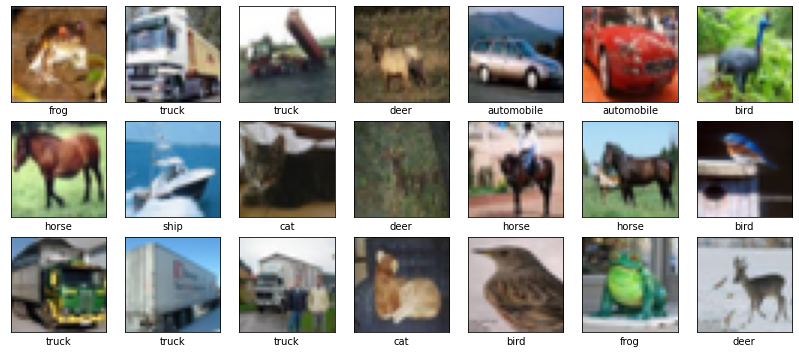

In [ ]:
print(x_train.shape, y_train.shape)
visualize_data(x_train, y_train, class_names)

In [ ]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[32,32,3], padding="same", use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))

prev_filters = 0
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
  strides = 1 if filters == prev_filters else 2
  model.add(ResidualUnit(filters, strides=strides)) # Adding Residual model
  prev_filters = filters

model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test)

Epoch 1/10
1563/1563 [==============================] - 237s 144ms/step - loss: 1.6711 - accuracy: 0.4172 - val_loss: 1.7664 - val_accuracy: 0.3901
Epoch 2/10
1563/1563 [==============================] - 224s 144ms/step - loss: 1.3310 - accuracy: 0.5309 - val_loss: 2.1064 - val_accuracy: 0.2804
Epoch 3/10
1563/1563 [==============================] - 225s 144ms/step - loss: 1.1291 - accuracy: 0.6086 - val_loss: 1.2066 - val_accuracy: 0.5740
Epoch 4/10
1563/1563 [==============================] - 225s 144ms/step - loss: 1.0491 - accuracy: 0.6393 - val_loss: 1.2090 - val_accuracy: 0.5686
Epoch 5/10
1563/1563 [==============================] - 229s 146ms/step - loss: 0.9384 - accuracy: 0.6781 - val_loss: 2.9413 - val_accuracy: 0.2870
Epoch 6/10
1563/1563 [==============================] - 224s 144ms/step - loss: 0.8651 - accuracy: 0.7046 - val_loss: 0.9575 - val_accuracy: 0.6681
Epoch 7/10
1563/1563 [==============================] - 224s 144ms/step - loss: 0.8430 - accuracy: 0.7133 - val_

# Exercise 8

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator

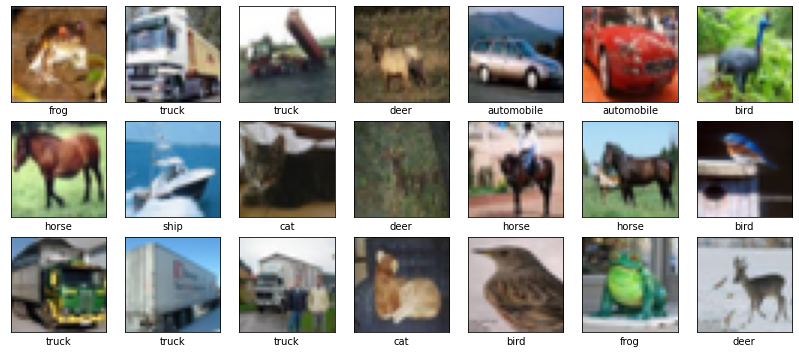

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train / 255.0
y_train = to_categorical(y_train, num_classes)

x_test = x_test / 255.0
y_test = to_categorical(y_test, num_classes)

visualize_data(x_train, y_train, class_names)

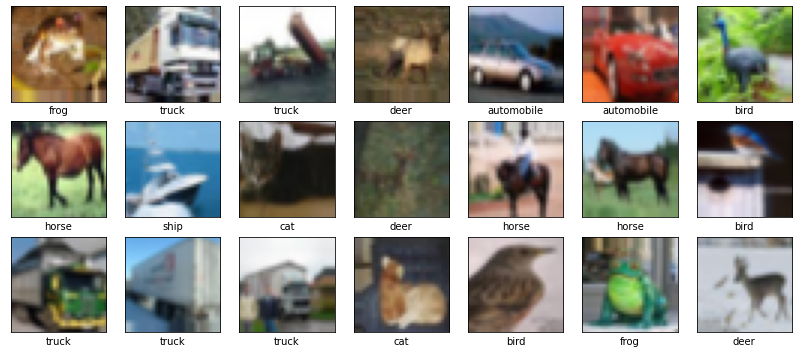

In [ ]:
width_shift = 3 / 32
height_shift = 3 / 32
flip = True

datagen = ImageDataGenerator(
    horizontal_flip=flip,
    width_shift_range=width_shift,
    height_shift_range=height_shift,
)
datagen.fit(x_train)

it = datagen.flow(x_train, y_train, shuffle=False)
batch_images, batch_labels = next(it)
visualize_data(batch_images, batch_labels, class_names)

In [ ]:
train_datagen = ImageDataGenerator(
    horizontal_flip=flip,
    width_shift_range=width_shift,
    height_shift_range=height_shift,
)
valid_datagen = ImageDataGenerator(rescale=1)

train_generator = train_datagen.flow(x_train, y=y_train, batch_size=32)
valid_generator = train_datagen.flow(x_test, y=y_test, batch_size=32)

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(train_generator, epochs=10, validation_data=valid_generator)
score = model.evaluate(x_test, y_test)

Epoch 1/10
1563/1563 [==============================] - 262s 160ms/step - loss: 0.8468 - accuracy: 0.7116 - val_loss: 3.8922 - val_accuracy: 0.3358
Epoch 2/10
1563/1563 [==============================] - 245s 157ms/step - loss: 0.8329 - accuracy: 0.7147 - val_loss: 1.1539 - val_accuracy: 0.6431
Epoch 3/10
1563/1563 [==============================] - 244s 156ms/step - loss: 0.7936 - accuracy: 0.7266 - val_loss: 4.5962 - val_accuracy: 0.1968
Epoch 4/10
1563/1563 [==============================] - 243s 156ms/step - loss: 0.8863 - accuracy: 0.6949 - val_loss: 0.9409 - val_accuracy: 0.6807
Epoch 5/10
1563/1563 [==============================] - 242s 155ms/step - loss: 0.7630 - accuracy: 0.7383 - val_loss: 1.0480 - val_accuracy: 0.6548
Epoch 6/10
1563/1563 [==============================] - 242s 155ms/step - loss: 0.7111 - accuracy: 0.7524 - val_loss: 0.8148 - val_accuracy: 0.7155
Epoch 7/10
1563/1563 [==============================] - 242s 155ms/step - loss: 0.7160 - accuracy: 0.7516 - val_

# Exercise 9

In [8]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical # return a binary matrix representation of the input
from tensorflow import keras
from tensorflow.keras.layers import Layer, Conv2D, BatchNormalization

In [9]:
class ResidualUnit50(Layer):

  def _main_layers(self, filters, strides, activation):
    return [
                   Conv2D(filters, (1,1), strides=strides, padding='valid', use_bias=False),
                   BatchNormalization(),
                   self.activation,
                   Conv2D(filters, (3,3), strides=1, padding='same', use_bias=False),
                   BatchNormalization(),
                   self.activation,
                   Conv2D(filters * 4, (1,1), strides=1, padding='valid', use_bias=False),
                   BatchNormalization(),
    ]
  
  def _skip_layers(self, filters, strides, activation):
    return [
                   Conv2D(filters * 4, (1,1), strides=strides, padding='valid', use_bias=False),
                   BatchNormalization(),
    ]

  def __init__(self, filters, strides=1, activation='relu', **kwargs):
    super(ResidualUnit50, self).__init__(**kwargs)
    self.activation = keras.activations.get(activation)
    self.main_layers = self._main_layers(filters, strides, activation)
    self.skip_layers = self._skip_layers(filters, strides, activation)

  def call(self, inputs):
    Z = inputs
    skip_Z = inputs
    for main_layer in self.main_layers:
      Z = main_layer(Z)
    for skip_layer in self.skip_layers: # adding skip_layers
      skip_Z = skip_layer(skip_Z)
    return self.activation(Z + skip_Z)
    

In [17]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[32,32,3], padding="same", use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))

def layer(filters, n, strides=1):
  layers = []
  for _ in range(n):
    model.add(ResidualUnit50(filters, strides))
    strides = 1
  return layers

layer(64, 3, strides=1)
layer(128, 4, strides=2)
layer(256, 6, strides=2)
layer(512, 3, strides=2)

model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_145 (Conv2D)         (None, 16, 16, 64)        9408      
                                                                 
 batch_normalization_145 (Ba  (None, 16, 16, 64)       256       
 tchNormalization)                                               
                                                                 
 activation_5 (Activation)   (None, 16, 16, 64)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 residual_unit50_36 (Residua  (None, 8, 8, 256)        76288     
 lUnit50)                                                        
                                                      

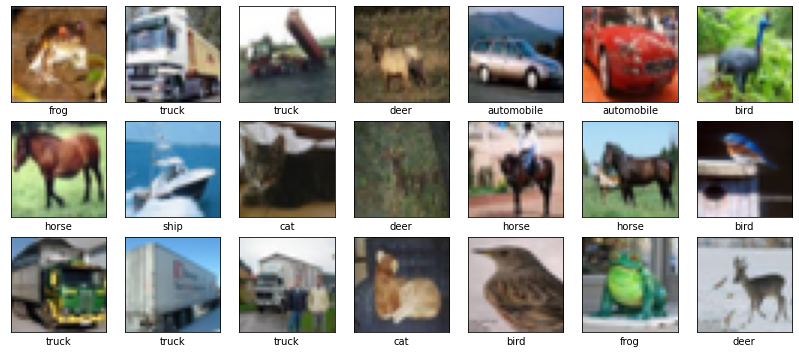

In [18]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train / 255.0
y_train = to_categorical(y_train, num_classes)

x_test = x_test / 255.0
y_test = to_categorical(y_test, num_classes)

visualize_data(x_train, y_train, class_names)

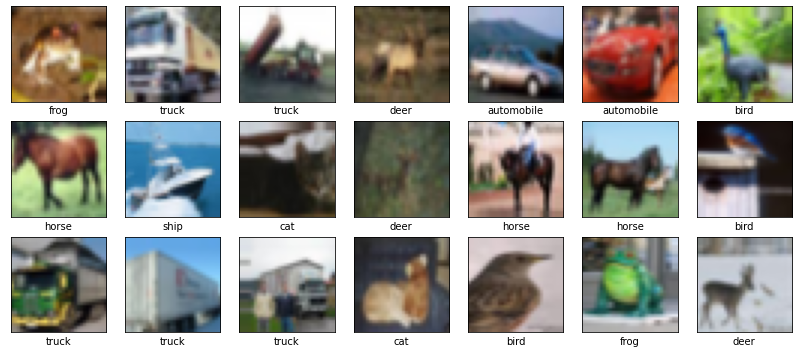

In [19]:
width_shift = 3 / 32
height_shift = 3 / 32
flip = True

datagen = ImageDataGenerator(
    horizontal_flip=flip,
    width_shift_range=width_shift,
    height_shift_range=height_shift,
)
datagen.fit(x_train)

it = datagen.flow(x_train, y_train, shuffle=False)
batch_images, batch_labels = next(it)
visualize_data(batch_images, batch_labels, class_names)

In [20]:
train_datagen = ImageDataGenerator(
    horizontal_flip=flip,
    width_shift_range=width_shift,
    height_shift_range=height_shift,
)
valid_datagen = ImageDataGenerator(rescale=1)

train_generator = train_datagen.flow(x_train, y=y_train, batch_size=32)
valid_generator = train_datagen.flow(x_test, y=y_test, batch_size=32)

In [21]:
model.compile(loss="categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(train_generator, epochs=15, validation_data=valid_generator)
score = model.evaluate(x_test, y_test)

Epoch 1/15
1563/1563 [==============================] - 402s 244ms/step - loss: 2.0074 - accuracy: 0.2964 - val_loss: 5.1395 - val_accuracy: 0.3033
Epoch 2/15
1563/1563 [==============================] - 380s 243ms/step - loss: 1.7353 - accuracy: 0.3790 - val_loss: 2.1706 - val_accuracy: 0.3383
Epoch 3/15
1563/1563 [==============================] - 380s 243ms/step - loss: 1.5960 - accuracy: 0.4260 - val_loss: 1.5828 - val_accuracy: 0.4259
Epoch 4/15
1563/1563 [==============================] - 380s 243ms/step - loss: 1.6442 - accuracy: 0.4136 - val_loss: 33.7856 - val_accuracy: 0.1394
Epoch 5/15
1563/1563 [==============================] - 380s 243ms/step - loss: 1.5596 - accuracy: 0.4442 - val_loss: 2.1060 - val_accuracy: 0.3899
Epoch 6/15
1563/1563 [==============================] - 380s 243ms/step - loss: 1.4156 - accuracy: 0.4973 - val_loss: 2.4496 - val_accuracy: 0.3098
Epoch 7/15
1563/1563 [==============================] - 382s 244ms/step - loss: 1.3476 - accuracy: 0.5303 - val